In [1]:

#####   RUN THIS CELL FIRST!   #####
##### IMPORTS ALL REQUIREMENTS #####
#####   & INCLUDES CONSTANTS   #####
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_1samp, linregress
pd.set_option('display.max_columns', None)

# Data Analysis Notebook

## Introduction

write stuff here on what is being done here

## Todo

1. Create table on mean, std, and other metrics for each demographics question.

2. Create a breakdown of overall performance on how people performed on the task.

3. Do an analysis on how different categories (poem, article, etc.) affected performance.

4. Do an analysis of how people performed based on prior knowledge

### Part 1: Data loading

In this section, we are loading the data and parsing it so that we can use it in the data analysis section. We are getting rid of all the unnecessary metadata that qualtrics includes for each response

In [2]:
##### Helper Functions #####
def parse_passage_response(x: str) -> int:
    parse_dict = {
        'Human Written': 0,
        'AI Generated': 1
    }
    
    return parse_dict.get(x, 0)

def parse_sf1_response(x: str) -> int:
    parse_dict = {
        '0': 1,
        '1': 2,
        '2': 3,
        '3': 4,
        '4+': 5,
    }
    
    return parse_dict.get(x, 1)

def parse_sf2_response(x: str) -> int:
    parse_dict = {
        'Rarely or never': 1,
        'A few times a month': 2,
        'Once a week': 3,
        'Several times a week': 4,
        'Daily': 5,
    }
    
    return parse_dict.get(x, 1)

def parse_edu_response(x: str) -> int:
    parse_dict = {
        'High school diploma or GED': 1,
        'Some college, but no degree': 2,
        'Associate Degree': 3,
        'Bachelor\'s Degree': 4,
        'Master\'s Degree or higher education': 5,
        'Other (Please fill in)': 0,
        'Prefer not to say': 0
    }
    
    return parse_dict.get(x, 0)

def parse_ta_response(x: str) -> int:
    if x == 'No':
        return 0
    return 1
    

In [3]:
# Load df
data_path = Path('./data/')
tsv_files = os.listdir(data_path)

print(tsv_files)

dfs = []
starting_value = 0
for tsv_file in tsv_files:
    print(tsv_file)
    new_df = pd.read_csv(data_path/tsv_file, sep='\t', encoding='UTF-16', quoting=3, skiprows=[1,2])
    new_df.index = np.arange(starting_value, starting_value+len(new_df))
    starting_value += len(new_df)
    dfs.append(new_df)

df = pd.concat(dfs)

# Removes extra metadata from dataframe
columns_to_keep = ["Duration (in seconds)", "Finished", "RecordedDate", "ResponseId", "ID", "Consent", "SF1_1", "SF1_2", "SF1_3", "SF2_1", "SF2_2", "SF2_3", "SF2_4", "SF2_5", "SF2_6", "SF2_7", "Age", "Education", "Education_7_TEXT", "Major", "TA Exp", "TA Exp_1_TEXT", "HU-S3", "AI-S1", "HU-P2", "AI-P1", "HU-N2", "AI-N1", "HU-W2", "AI-W3", "Strategy", "Patterns"]
df = df[columns_to_keep].reset_index(drop=True) 

# Keep finished responses
df = df[(pd.notna(df['ID'])) | (df['Consent']=='Yes')]
df = df[df['Finished']==True]

# Columns for reference
sf1_cols = [x for x in df.columns if 'SF1' in x]
sf2_cols = [x for x in df.columns if 'SF2' in x]
passage_cols = [x for x in df.columns if x[:2] in ('AI', 'HU')]
true_answers = [0 if x[:2] == 'HU' else 1 for x in passage_cols]

# Parsing responses
df[sf1_cols] = df[sf1_cols].applymap(parse_sf1_response)
df[sf2_cols] = df[sf2_cols].applymap(parse_sf2_response)
df[passage_cols] = df[passage_cols].applymap(parse_passage_response)
df['Education'] = df['Education'].map(parse_edu_response)
df['TA Exp'] = df['TA Exp'].map(parse_ta_response)

df


['Group 6 Questionnaire (Broad)_December 5, 2023_11.34.tsv', 'Group 6 Questionnaire (Class)_December 5, 2023_11.34.tsv']
Group 6 Questionnaire (Broad)_December 5, 2023_11.34.tsv
Group 6 Questionnaire (Class)_December 5, 2023_11.34.tsv


C:\Users\willi\AppData\Local\Temp\ipykernel_30296\1872190869.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[sf1_cols] = df[sf1_cols].applymap(parse_sf1_response)
C:\Users\willi\AppData\Local\Temp\ipykernel_30296\1872190869.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[sf2_cols] = df[sf2_cols].applymap(parse_sf2_response)
C:\Users\willi\AppData\Local\Temp\ipykernel_30296\1872190869.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[passage_cols] = df[passage_cols].applymap(parse_passage_response)


,Duration (in seconds),Finished,RecordedDate,ResponseId,ID,Consent,SF1_1,SF1_2,SF1_3,SF2_1,SF2_2,SF2_3,SF2_4,SF2_5,SF2_6,SF2_7,Age,Education,Education_7_TEXT,Major,TA Exp,TA Exp_1_TEXT,HU-S3,AI-S1,HU-P2,AI-P1,HU-N2,AI-N1,HU-W2,AI-W3,Strategy,Patterns
0,451.0,True,2023-11-13 19:28:54,R_3h0H4nneVVU8gyp,NaN,Yes,3,1,5,2,3,5,1,3,1,4,20.0,2,NaN,Computer Science,0,NaN,0,0,0,1,1,1,1,1,AI Generated text has a cadence to it that's v...,Human text reads like it's describing a scene ...
1,396.0,True,2023-11-13 19:30:57,R_1ClQwZC5Sjv9rSB,NaN,Yes,1,1,1,1,1,2,1,2,2,2,19.0,1,NaN,NaN,0,NaN,0,1,0,1,1,0,1,1,I tried to look for specific patterns in writi...,"In my opinion, it just felt more life-like and..."
2,411.0,True,2023-11-13 19:50:04,R_1JCRIPGTmHEbDPu,NaN,Yes,1,1,4,2,1,1,1,2,2,2,22.0,2,NaN,Creative Writing,0,NaN,0,0,1,0,1,0,0,1,I mostly just looked for lines that felt wrong...,"""The AI, in my opinion, used more details. How..."
3,445.0,True,2023-11-13 19:50:48,R_2D5IQXnVn1RqoF7,NaN,Yes,4,1,4,3,3,1,3,4,4,1,21.0,2,NaN,Robotics Engineering,1,Program Aide Summer camp,0,1,0,1,0,1,0,1,If it cussed then it was a human because I can...,I think the ones i marked AI sounded too formal
4,1111.0,True,2023-11-13 20:06:54,R_VKdXjaegc3N4i6R,NaN,Yes,3,1,5,2,2,2,2,3,1,1,21.0,4,NaN,Computer Science,1,"CS, Head TA",0,0,0,0,0,0,0,0,I looked for tone and mistakes. I feel like sm...,It felt like most of these were human generate...
5,348.0,True,2023-11-13 20:18:24,R_1ZAXPOXFRpVcmT7,NaN,Yes,1,1,1,1,1,3,1,1,1,1,23.0,4,NaN,Business Administration,0,NaN,0,1,0,1,0,0,1,1,Forced formality and style,Forced formality and a lack of unique style fe...
6,186.0,True,2023-11-13 21:09:42,R_28V3ketyqTfKzNp,NaN,Yes,2,1,5,2,5,3,3,2,1,1,29.0,5,NaN,"""HCDE """,0,NaN,0,1,1,1,1,0,1,1,NaN,NaN
8,418.0,True,2023-11-14 00:16:52,R_3eesWl2qJDirvqP,NaN,Yes,3,1,5,1,2,3,1,4,1,2,23.0,1,NaN,NaN,0,NaN,0,1,1,0,0,0,1,0,NaN,NaN
9,599.0,True,2023-11-14 00:18:34,R_3k85Klo00SV4cW9,NaN,Yes,1,1,5,4,5,4,2,3,3,1,31.0,4,NaN,"""Computer Science """,0,NaN,0,1,0,1,1,0,0,1,"""Formatting, and average sentence length. """,NaN
10,617.0,True,2023-11-14 09:55:26,R_2to22jnsqQmcUwj,NaN,Yes,1,1,2,1,2,5,2,1,2,2,27.0,5,NaN,Engineering,0,NaN,0,1,0,0,0,1,0,0,I look for cohesiveness and deeper meaning in ...,I assumed the one text with confusing word rep...


In [4]:
# Aggregating scores for Source Familiarity
df['SF1_AVG'] = df[sf1_cols].mean(axis=1)
df['SF2_AI_AVG'] = df[sf2_cols[:2]].mean(axis=1)
df['SF2_HU_AVG'] = df[sf2_cols[2:]].mean(axis=1)

# Aggregating scores for passsages
df['ANS_TOTAL'] = (df[passage_cols] == true_answers).sum(axis=1)
df['ANS_STORY'] = (df[passage_cols[0:2]] == true_answers[0:2]).sum(axis=1)
df['ANS_POEM'] = (df[passage_cols[2:4]] == true_answers[2:4]).sum(axis=1)
df['ANS_NEWS'] = (df[passage_cols[4:6]] == true_answers[4:6]).sum(axis=1)
df['ANS_WIKI'] = (df[passage_cols[6:8]] == true_answers[6:8]).sum(axis=1)

# Expressing as percentages
df['ANS_TOTAL (%)'] = (df['ANS_TOTAL'] / 8) * 100
df['ANS_STORY (%)'] = (df['ANS_STORY'] / 2) * 100
df['ANS_POEM (%)'] = (df['ANS_POEM'] / 2) * 100
df['ANS_NEWS (%)'] = (df['ANS_NEWS'] / 2) * 100
df['ANS_WIKI (%)'] = (df['ANS_WIKI'] / 2) * 100

agg_sf_list = [df['SF1_AVG'], df['SF2_AI_AVG'], df['SF2_HU_AVG']]
answer_list = [df['ANS_TOTAL (%)'], df['ANS_STORY (%)'], df['ANS_POEM (%)'], df['ANS_NEWS (%)'], df['ANS_WIKI (%)']]

answer_list_np = [df['ANS_TOTAL'], df['ANS_STORY'], df['ANS_POEM'], df['ANS_NEWS'], df['ANS_WIKI']]

data_cols = ['SF1_AVG', 'SF2_AI_AVG', 'SF2_HU_AVG', 'TA Exp', 'Education', 'ANS_TOTAL (%)', 'ANS_STORY (%)', 'ANS_POEM (%)', 'ANS_NEWS (%)', 'ANS_WIKI (%)']

df[data_cols]

,SF1_AVG,SF2_AI_AVG,SF2_HU_AVG,TA Exp,Education,ANS_TOTAL (%),ANS_STORY (%),ANS_POEM (%),ANS_NEWS (%),ANS_WIKI (%)
0,3.000000,2.5,2.8,0,2,62.5,50.0,100.0,50.0,50.0
1,1.000000,1.0,1.8,0,1,62.5,100.0,100.0,0.0,50.0
2,2.000000,1.5,1.6,0,2,37.5,50.0,0.0,0.0,100.0
3,3.000000,3.0,2.6,1,2,100.0,100.0,100.0,100.0,100.0
4,3.000000,2.0,1.8,1,4,50.0,50.0,50.0,50.0,50.0
5,1.000000,1.0,1.4,0,4,75.0,100.0,100.0,50.0,50.0
6,2.666667,3.5,2.0,0,5,50.0,100.0,50.0,0.0,50.0
8,3.000000,1.5,2.2,0,1,37.5,100.0,0.0,50.0,0.0
9,2.333333,4.5,2.6,0,4,75.0,100.0,100.0,0.0,100.0
10,1.333333,1.5,2.4,0,5,75.0,100.0,50.0,100.0,50.0


### Part 2: Descriptive Statistics

In [5]:
print('\nSample means of independent variables:')
for sf_series in agg_sf_list:
    col_name = sf_series.name
    mean = sf_series.mean()
    std = sf_series.std()
    print(f'Column: {col_name}, Mean: {mean:.2f}, Std: {std:.2f}')

print('\nSample means of answers (%) w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):')

for ans_series in answer_list:
    col_name = ans_series.name
    mean = ans_series.mean()
    std = ans_series.std()
    
    test = ttest_1samp(ans_series, 50)
    signif = ''.join(['*' for t in [.05, .01, .001] if test.pvalue <= t])
    print(f'Column: {col_name}, Mean: {mean:.2f}{signif}, Std: {std:.2f}')
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance\
rho = df[data_cols].corr()
pval = df[data_cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))
corr_matrix_signifcance = rho.round(3).astype(str) + p



print('\nCorrelation Matrix w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):')
corr_matrix_signifcance


Sample means of independent variables:
Column: SF1_AVG, Mean: 2.53, Std: 0.97
Column: SF2_AI_AVG, Mean: 2.25, Std: 1.28
Column: SF2_HU_AVG, Mean: 2.14, Std: 0.88

Sample means of answers (%) w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):
Column: ANS_TOTAL (%), Mean: 59.23**, Std: 18.74
Column: ANS_STORY (%), Mean: 70.24***, Std: 31.35
Column: ANS_POEM (%), Mean: 55.95, Std: 38.58
Column: ANS_NEWS (%), Mean: 48.81, Std: 39.02
Column: ANS_WIKI (%), Mean: 61.90*, Std: 34.59

Correlation Matrix w/ Stastical Signicance (*=0.05, **=0.01, ***=0.001):


,SF1_AVG,SF2_AI_AVG,SF2_HU_AVG,TA Exp,Education,ANS_TOTAL (%),ANS_STORY (%),ANS_POEM (%),ANS_NEWS (%),ANS_WIKI (%)
SF1_AVG,1.0***,0.551***,0.442**,0.047,-0.089,0.009,0.039,0.088,-0.155,0.061
SF2_AI_AVG,0.551***,1.0***,0.407**,-0.0,0.031,0.06,-0.084,0.241,-0.189,0.152
SF2_HU_AVG,0.442**,0.407**,1.0***,0.213,-0.201,0.014,0.069,0.175,-0.08,-0.137
TA Exp,0.047,-0.0,0.213,1.0***,0.14,0.004,-0.219,0.083,0.094,0.008
Education,-0.089,0.031,-0.201,0.14,1.0***,0.221,0.129,0.087,0.165,0.079
ANS_TOTAL (%),0.009,0.06,0.014,0.004,0.221,1.0***,0.427**,0.555***,0.62***,0.461**
ANS_STORY (%),0.039,-0.084,0.069,-0.219,0.129,0.427**,1.0***,0.2,0.02,-0.228
ANS_POEM (%),0.088,0.241,0.175,0.083,0.087,0.555***,0.2,1.0***,-0.036,-0.054
ANS_NEWS (%),-0.155,-0.189,-0.08,0.094,0.165,0.62***,0.02,-0.036,1.0***,0.237
ANS_WIKI (%),0.061,0.152,-0.137,0.008,0.079,0.461**,-0.228,-0.054,0.237,1.0***


[Text(0, 1, 'SF2_HU_AVG'), Text(0, 2, 'SF2_AI_AVG'), Text(0, 3, 'SF1_AVG')]

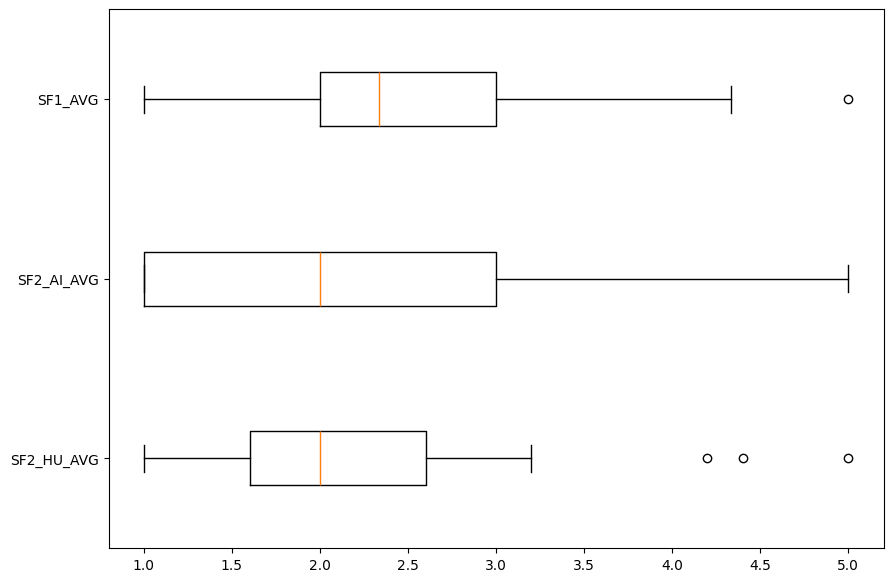

In [6]:
fig = plt.figure(figsize =(10, 7))

ax = fig.add_subplot(111)
ax.boxplot(agg_sf_list[::-1], vert=0)
ax.set_yticklabels([s.name for s in agg_sf_list[::-1]])

[Text(0, 1, 'ANS_WIKI (%)'),
 Text(0, 2, 'ANS_NEWS (%)'),
 Text(0, 3, 'ANS_POEM (%)'),
 Text(0, 4, 'ANS_STORY (%)'),
 Text(0, 5, 'ANS_TOTAL (%)')]

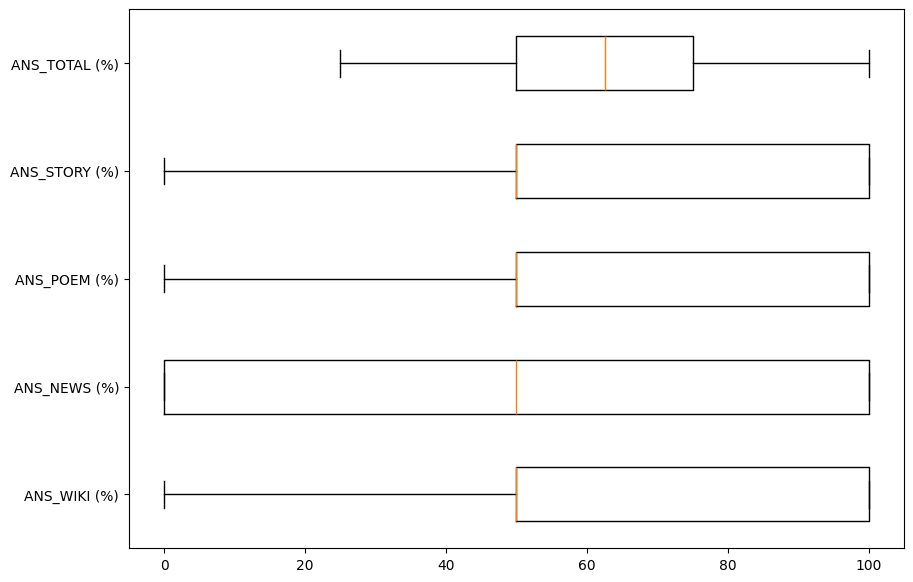

In [7]:
fig = plt.figure(figsize =(10, 7))

ax = fig.add_subplot(111)
ax.boxplot(answer_list[::-1], vert=0)
ax.set_yticklabels([s.name for s in answer_list[::-1]])

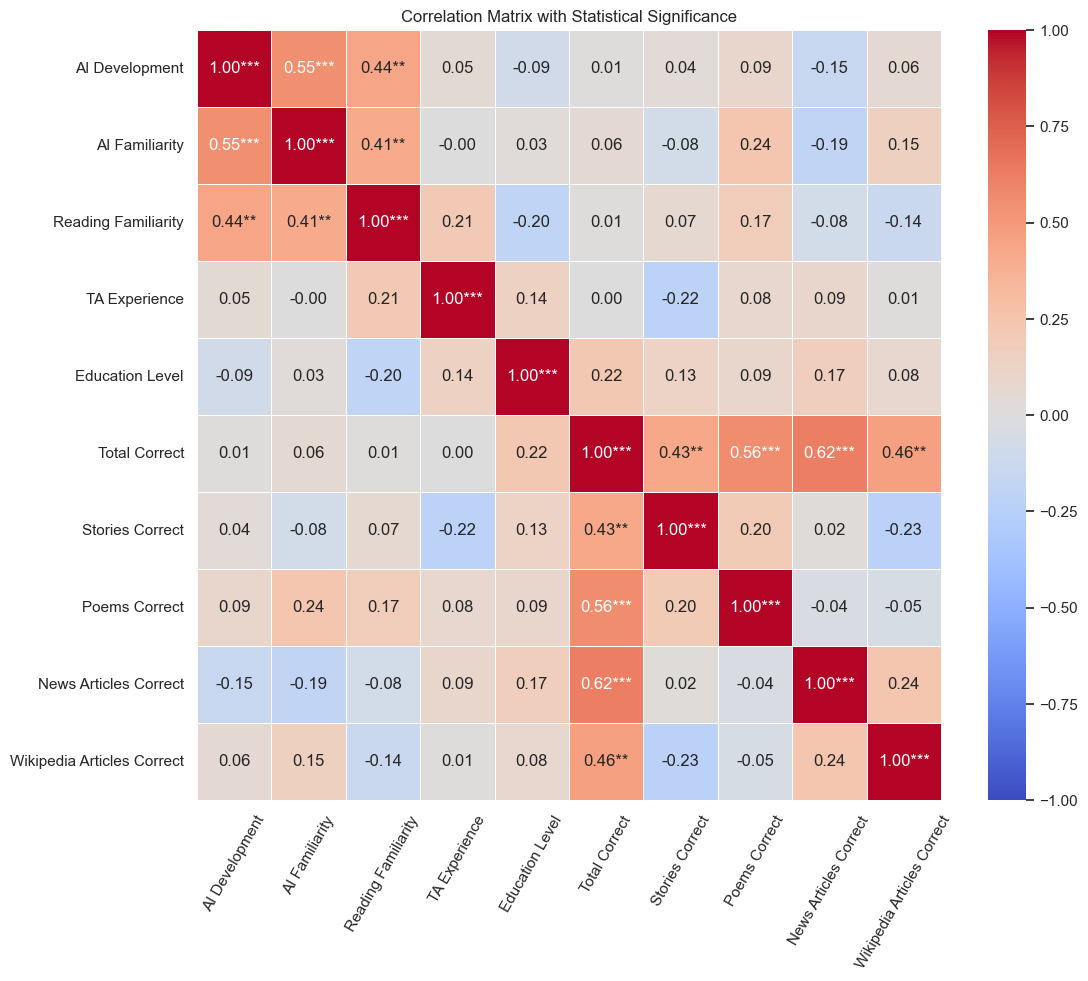

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import ttest_1samp

rho = df[data_cols].corr()

pval = df[data_cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
significance = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))
coefficients = rho.map(lambda x: float(x))

annot = rho.round(3).map(lambda x: f'{x:.2f}') + significance


labels = ['AI Development', 'AI Familiarity', 'Reading Familiarity', 'TA Experience', 'Education Level', 'Total Correct', 'Stories Correct', 'Poems Correct', 'News Articles Correct', 'Wikipedia Articles Correct']
plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
ax = sns.heatmap(coefficients, annot=annot, cmap='coolwarm', fmt='', linewidths=.5, xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1)
ax.set_xticklabels(labels, rotation=60)
plt.title('Correlation Matrix with Statistical Significance')
plt.show()

Regression results for AI Development vs Total Correct: (H_a: s > 0)
Slope: 0.013492008579533643
Intercept: 4.70393689891372
R-value: 0.008692305676147077
P-value: 0.47821521844964954
Slope Std Err: 0.24541167246504783
Intercept Std Err: 0.663978313324071



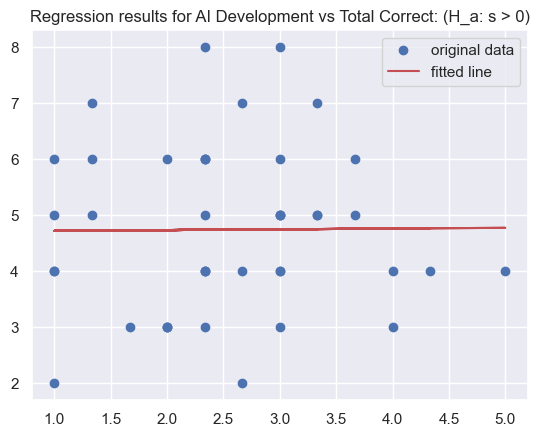

Regression results for AI Familiarity vs Total Correct: (H_a: s > 0)
Slope: 0.07076350093109864
Intercept: 4.578877361000266
R-value: 0.06040553576054108
P-value: 0.35197053532969147
Slope Std Err: 0.18488802891577205
Intercept Std Err: 0.4771656747915992



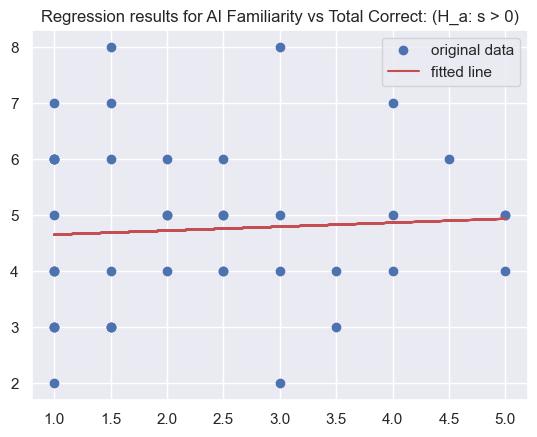

Regression results for Reading Familiarity vs Total Correct: (H_a: s > 0)
Slope: 0.024271844660194046
Intercept: 4.686084142394822
R-value: 0.014256881249400033
P-value: 0.46429806786661254
Slope Std Err: 0.26915603038142716
Intercept Std Err: 0.6224765776177961



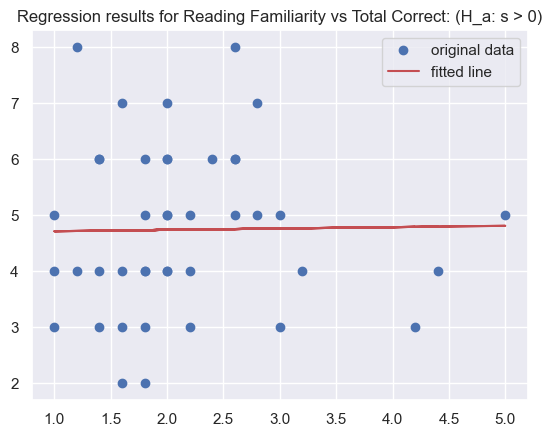

Regression results for TA Experience vs Total Correct: (H_a: s > 0)
Slope: 0.014705882352941027
Intercept: 4.735294117647059
R-value: 0.0038992059490723006
P-value: 0.49022401873008636
Slope Std Err: 0.596323076085996
Intercept Std Err: 0.2602567271250464



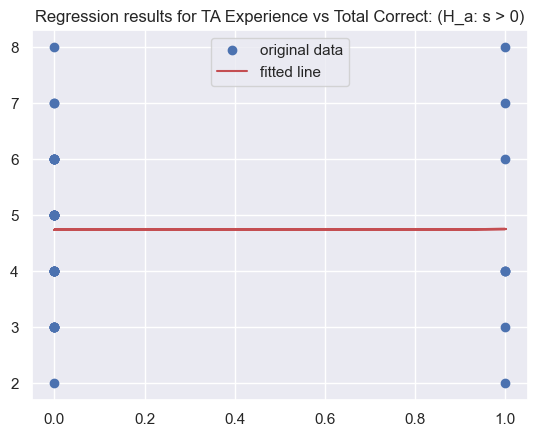

Regression results for Education Level vs Total Correct: (H_a: s > 0)
Slope: 0.268292682926829
Intercept: 4.060975609756098
R-value: 0.22094866351752454
P-value: 0.07984047171817617
Slope Std Err: 0.18724886513024303
Intercept Std Err: 0.524869720174311



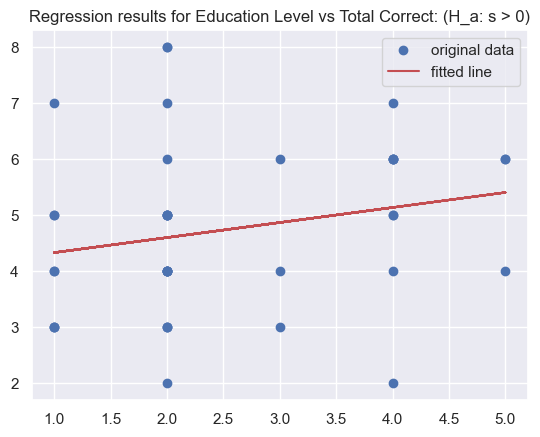

Regression results for AI Development vs Stories Correct: (H_a: s > 0)
Slope: 0.02511589289420881
Intercept: 1.341174842593233
R-value: 0.03868227736415519
P-value: 0.4039193106188598
Slope Std Err: 0.10258442470641714
Intercept Std Err: 0.277549281196427



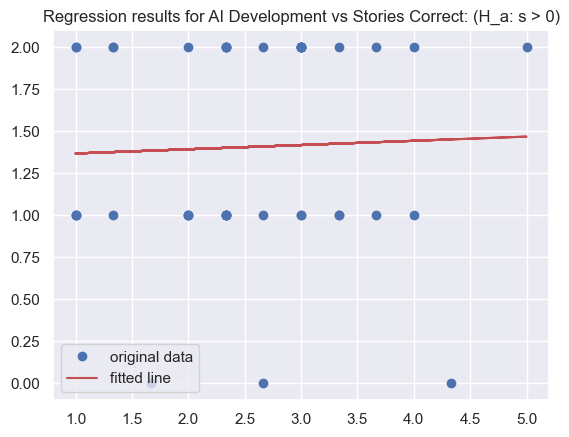

Regression results for AI Familiarity vs Stories Correct: (H_a: s > 0)
Slope: -0.040968342644320296
Intercept: 1.4969406757116253
R-value: -0.083602806235005
P-value: 0.7006879402962423
Slope Std Err: 0.07721016489455884
Intercept Std Err: 0.19926677053529865



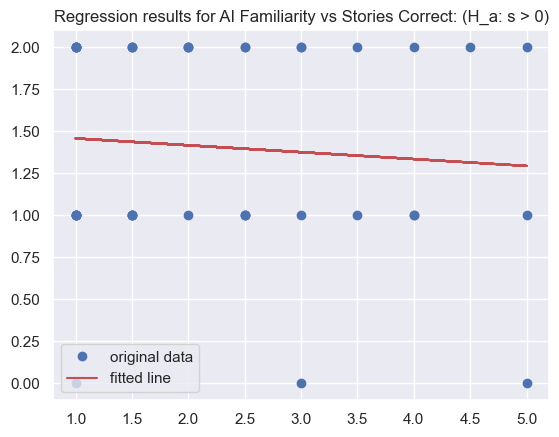

Regression results for Reading Familiarity vs Stories Correct: (H_a: s > 0)
Slope: 0.049442646530025176
Intercept: 1.2988133764832792
R-value: 0.06942701417222978
P-value: 0.3310963579395554
Slope Std Err: 0.11232955055782072
Intercept Std Err: 0.25978431208651964



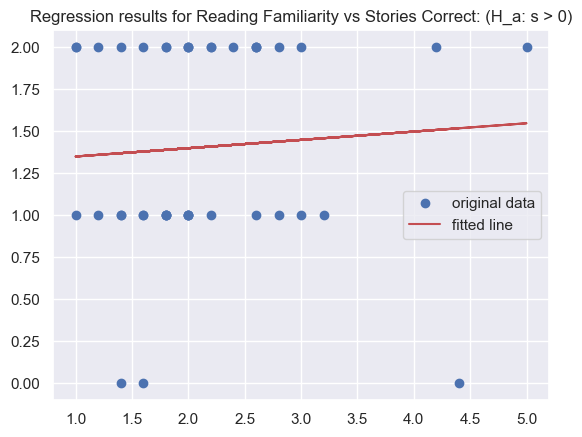

Regression results for TA Experience vs Stories Correct: (H_a: s > 0)
Slope: -0.34558823529411786
Intercept: 1.4705882352941175
R-value: -0.21905293033646295
P-value: 0.9183075471122427
Slope Std Err: 0.243389572489332
Intercept Std Err: 0.1062239180281243



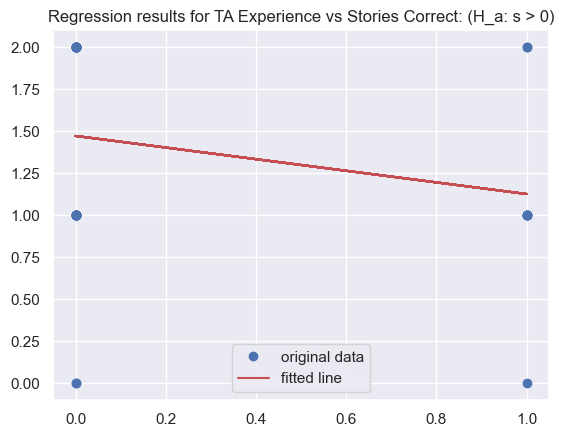

Regression results for Education Level vs Stories Correct: (H_a: s > 0)
Slope: 0.06554878048780481
Intercept: 1.239329268292683
R-value: 0.12904827308288813
P-value: 0.20767837814084122
Slope Std Err: 0.07964081964624817
Intercept Std Err: 0.22323796031075466



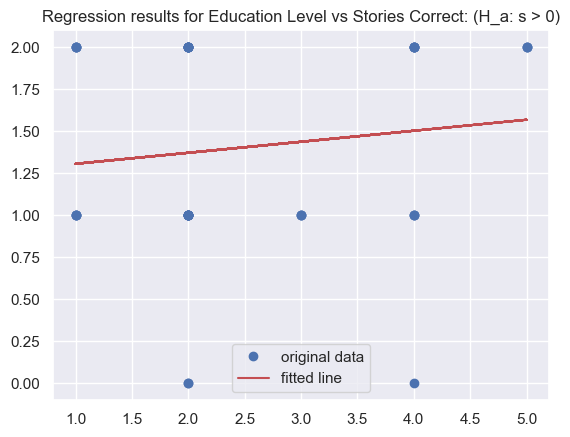

Regression results for AI Development vs Poems Correct: (H_a: s > 0)
Slope: 0.06995087525081294
Intercept: 0.9419497682142117
R-value: 0.08755661575487492
P-value: 0.29069066254076503
Slope Std Err: 0.1258354744840429
Intercept Std Err: 0.3404566101726423



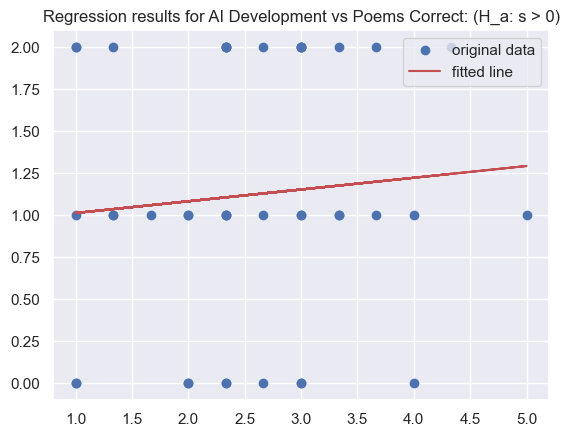

Regression results for AI Familiarity vs Poems Correct: (H_a: s > 0)
Slope: 0.14525139664804468
Intercept: 0.7922319765895185
R-value: 0.24089355391830133
P-value: 0.062172960611182215
Slope Std Err: 0.09253025231289937
Intercept Std Err: 0.2388054031536874



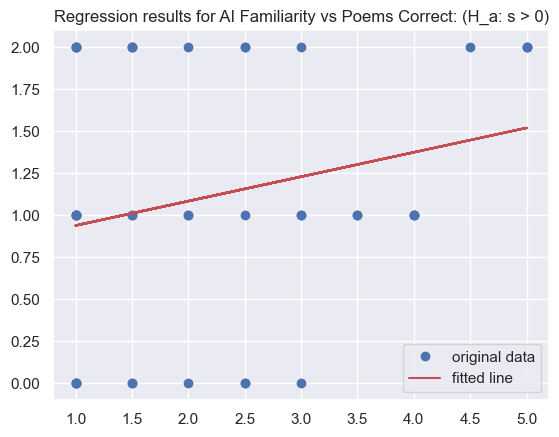

Regression results for Reading Familiarity vs Poems Correct: (H_a: s > 0)
Slope: 0.1537216828478965
Intercept: 0.7896440129449838
R-value: 0.17542614127968878
P-value: 0.1332355721750352
Slope Std Err: 0.13640279757522042
Intercept Std Err: 0.3154584591390793



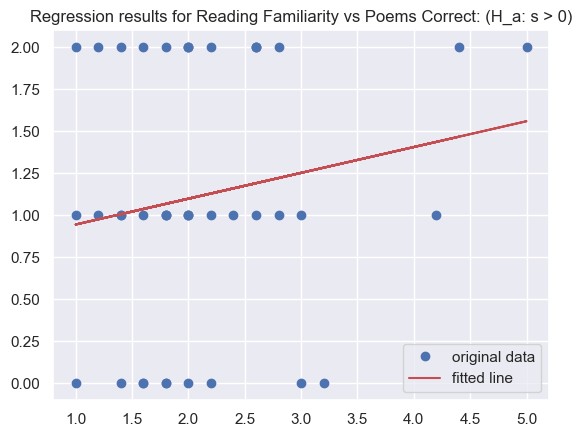

Regression results for TA Experience vs Poems Correct: (H_a: s > 0)
Slope: 0.1617647058823529
Intercept: 1.0882352941176472
R-value: 0.08333094209864267
P-value: 0.299908944008179
Slope Std Err: 0.30586821234283135
Intercept Std Err: 0.13349183197541434



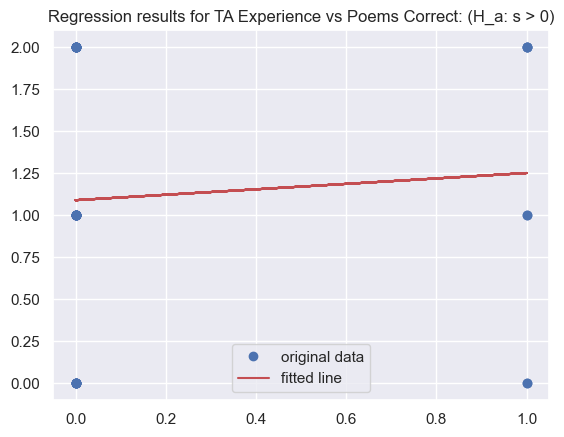

Regression results for Education Level vs Poems Correct: (H_a: s > 0)
Slope: 0.05411585365853657
Intercept: 0.982469512195122
R-value: 0.08658536585365853
P-value: 0.2927981251649302
Slope Std Err: 0.09845004753462638
Intercept Std Err: 0.2759613462260769



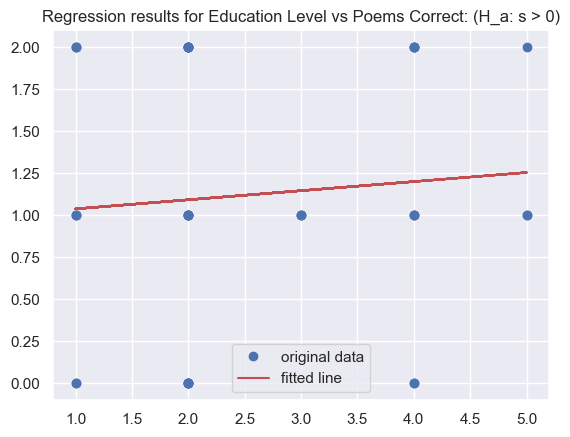

Regression results for AI Development vs News Articles Correct: (H_a: s > 0)
Slope: -0.12557946447104398
Intercept: 1.2941257870338334
R-value: -0.15537767880610476
P-value: 0.8370874494734021
Slope Std Err: 0.12623891859440145
Intercept Std Err: 0.34154815621536183



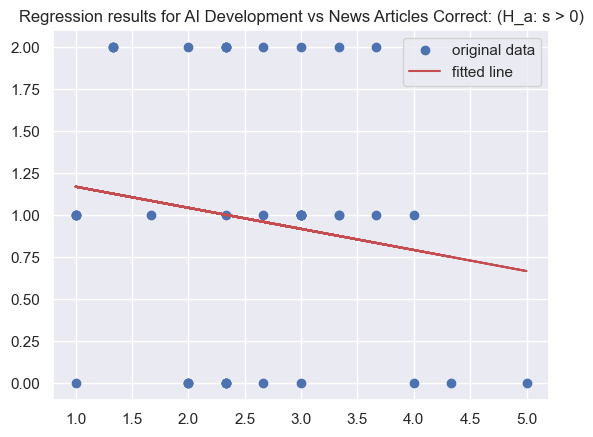

Regression results for AI Familiarity vs News Articles Correct: (H_a: s > 0)
Slope: -0.11545623836126627
Intercept: 1.2359670125033253
R-value: -0.18927639437268126
P-value: 0.8850314888039201
Slope Std Err: 0.09470409591761034
Intercept Std Err: 0.24441573691415958



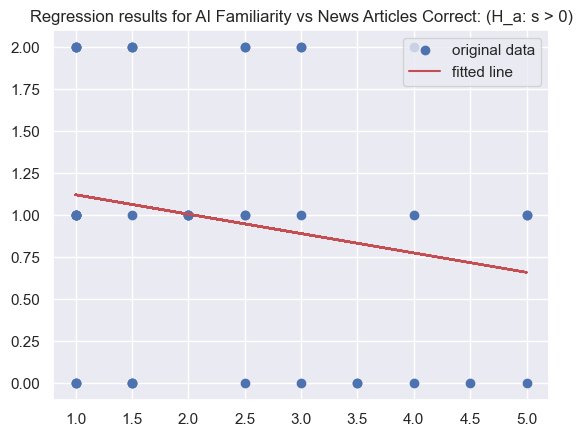

Regression results for Reading Familiarity vs News Articles Correct: (H_a: s > 0)
Slope: -0.07101761956130889
Intercept: 1.128371089536138
R-value: -0.0801123516027657
P-value: 0.692985570251659
Slope Std Err: 0.1397135395314313
Intercept Std Err: 0.32311520500264884



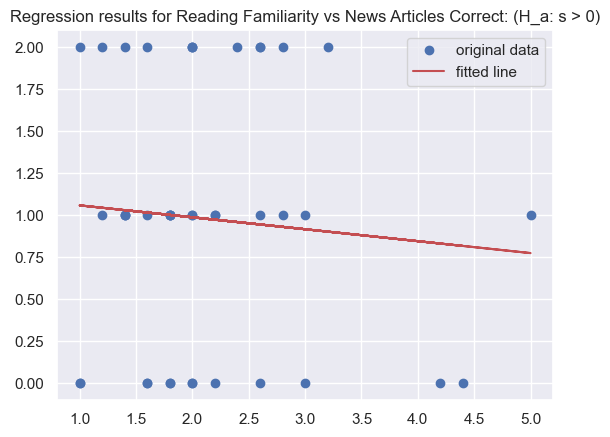

Regression results for TA Experience vs News Articles Correct: (H_a: s > 0)
Slope: 0.18382352941176455
Intercept: 0.9411764705882353
R-value: 0.09360473287079754
P-value: 0.2777234705702145
Slope Std Err: 0.3091450532150493
Intercept Std Err: 0.13492196257896327



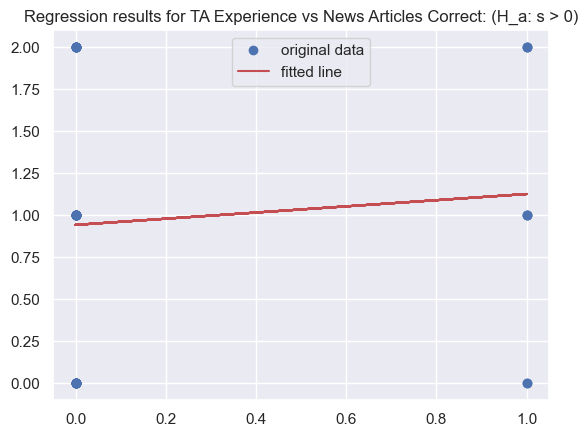

Regression results for Education Level vs News Articles Correct: (H_a: s > 0)
Slope: 0.10442073170731705
Intercept: 0.7126524390243902
R-value: 0.1651508842655524
P-value: 0.14796565404043358
Slope Std Err: 0.09859863744661013
Intercept Std Err: 0.2763778525983285



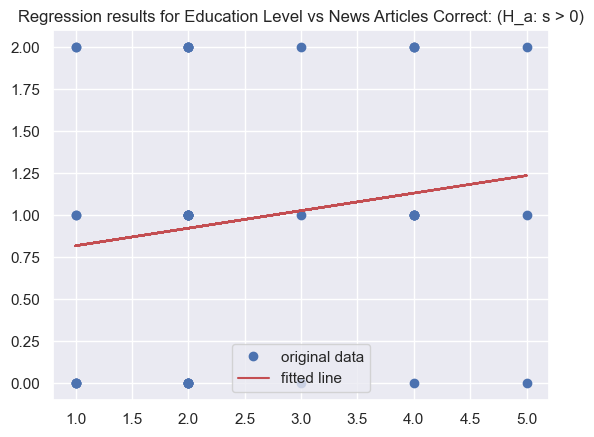

Regression results for AI Development vs Wikipedia Articles Correct: (H_a: s > 0)
Slope: 0.044004704905555934
Intercept: 1.1266865010724418
R-value: 0.061431801848132336
P-value: 0.34957277359214267
Slope Std Err: 0.11304590336385237
Intercept Std Err: 0.3058535378117227



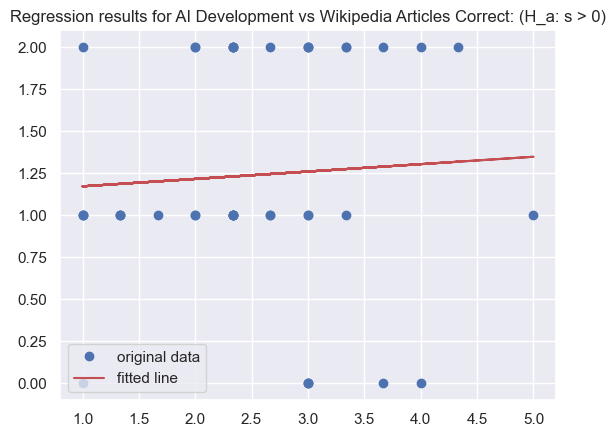

Regression results for AI Familiarity vs Wikipedia Articles Correct: (H_a: s > 0)
Slope: 0.08193668528864054
Intercept: 1.053737696195797
R-value: 0.15155894709248113
P-value: 0.16900052276061622
Slope Std Err: 0.08449300181473517
Intercept Std Err: 0.21806257799666892



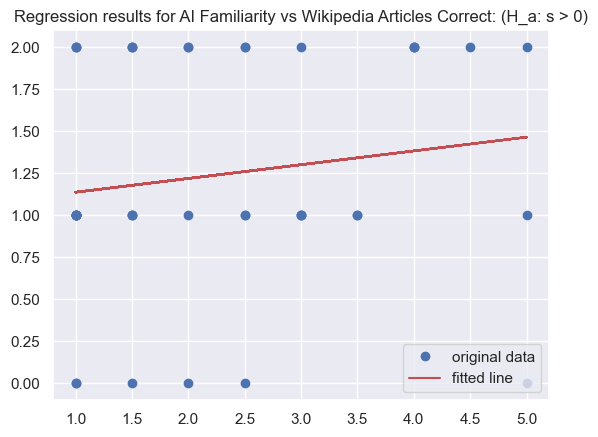

Regression results for Reading Familiarity vs Wikipedia Articles Correct: (H_a: s > 0)
Slope: -0.10787486515641856
Intercept: 1.4692556634304208
R-value: -0.13730228760903837
P-value: 0.8070519952757857
Slope Std Err: 0.12304947826837466
Intercept Std Err: 0.28457626604764574



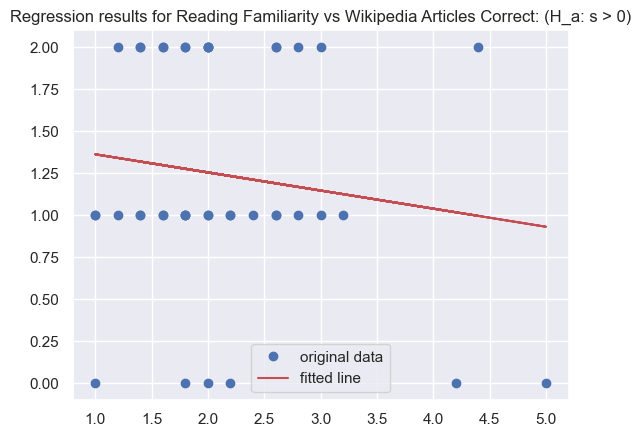

Regression results for TA Experience vs Wikipedia Articles Correct: (H_a: s > 0)
Slope: 0.014705882352941207
Intercept: 1.2352941176470589
R-value: 0.008449128855233306
P-value: 0.4788241128473392
Slope Std Err: 0.2751906385458136
Intercept Std Err: 0.12010304111232599



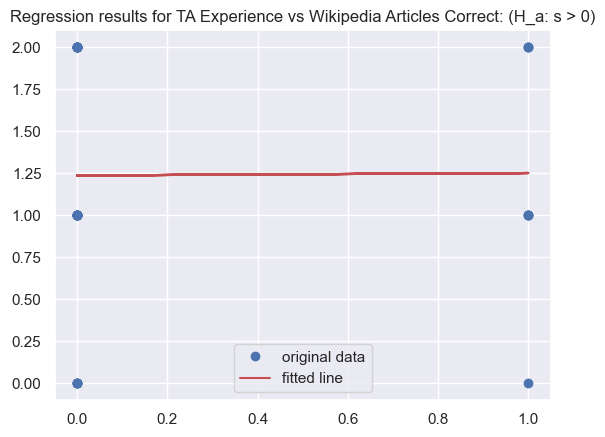

Regression results for Education Level vs Wikipedia Articles Correct: (H_a: s > 0)
Slope: 0.04420731707317073
Intercept: 1.1265243902439024
R-value: 0.07888827650858467
P-value: 0.30973534616940923
Slope Std Err: 0.08832753015921684
Intercept Std Err: 0.24758732719746865



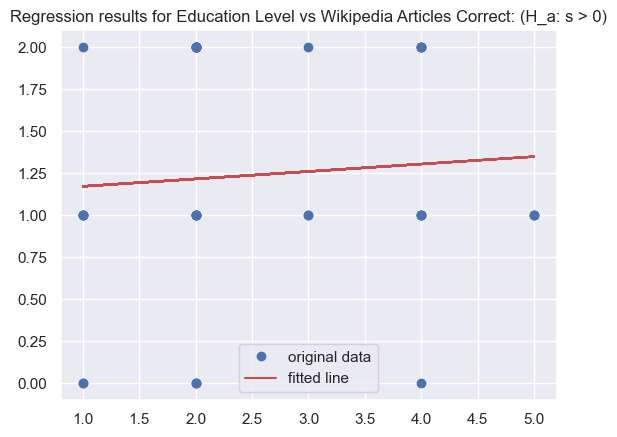

In [9]:
lin_x_rows = ['SF1_AVG', 'SF2_AI_AVG', 'SF2_HU_AVG', 'TA Exp', 'Education']
lin_x_names = ['AI Development', 'AI Familiarity', 'Reading Familiarity', 'TA Experience', 'Education Level']

lin_y_rows = ['ANS_TOTAL', 'ANS_STORY', 'ANS_POEM', 'ANS_NEWS', 'ANS_WIKI']
lin_y_names = ['Total Correct', 'Stories Correct', 'Poems Correct', 'News Articles Correct', 'Wikipedia Articles Correct']


for y_row, y_name in zip(lin_y_rows, lin_y_names):
    for x_row, x_name in zip(lin_x_rows, lin_x_names):
        print(f'Regression results for {x_name} vs {y_name}: (H_a: s > 0)')
        reg = linregress(df[x_row], df[y_row], alternative='greater')
        print(f'Slope: {reg.slope}\nIntercept: {reg.intercept}\nR-value: {reg.rvalue}\nP-value: {reg.pvalue}\nSlope Std Err: {reg.stderr}\nIntercept Std Err: {reg.intercept_stderr}\n')
        plt.plot(df[x_row], df[y_row], 'o', label='original data')
        plt.plot(df[x_row], reg.intercept + reg.slope*df[x_row], 'r', label='fitted line')
        plt.legend()
        plt.title(f'Regression results for {x_name} vs {y_name}: (H_a: s > 0)')
        plt.show()
        